### Econ Problem Set 3: Overlapping Generations Models

#### Dr. Evans, Boot Camp 2018
#### Name: Zunda Xu (zunda@uchicago.edu)

In [1]:
# First import the libraries and packages used in this problem set
import numpy as np
import time
import scipy.optimize as opt
import scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Set the parameters following the calibration

# beta: 20-year discount factor
beta = 0.96**20 
# delta: 20-year capital depreciation rate
delta = 1 - (1 - 0.05)**20 
# sigma: risk-aversion parameter
sigma = 3
# A: productivity scale parameter
A = 1
# alpha: capital share of income
alpha = 0.35                  

#### Exercise 2.1 - Write a feasible function

In [6]:
def feasible(f_params, bvec_guess):
    """
    Inputs: 
    f_params: A tuple, which is in the format of (nvec, A, alpha, delta), where
              nvec represents labour supply of various generations, A means 
              productivity scale parameter, alpha is capital share of income and
              delta represents 20-year capital depreciation rate.
    bvec_guess: a guess for the steady-state savings vector.
   
    Returns:
    b_cnstr : ith entry True if ith bvec_guess is responsible for any nonnegativity
              constraint violation in c_cnstr.
    c_cnstr : True if c_s <= 0 for s=1,2,3.
    K_cnstr : True if K <= 0.
    
    """
    b_cnstr = np.array([False, False])
    c_cnstr = np.array([False, False, False])
    K_cnstr = bvec_guess.sum() <= 0
    
    c = np.zeros((3, 1))
    K = bvec_guess.sum()
    L = f_params[0].sum()
    r = f_params[2] * f_params[1] * (L / K)**(1 - f_params[2]) - f_params[3]
    w = (1 - f_params[2]) * f_params[1] * (K / L)**f_params[2]
    c[0] = w * f_params[0][0] - bvec_guess[0]
    c[1] = w * f_params[0][1] + (1 + r) * bvec_guess[1]
    c[2] = w * f_params[0][2] + (1 + r) * bvec_guess[1]
    
    c_cnstr = c <= 0
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2]:
        b_cnstr[1] = True
        
    return b_cnstr, c_cnstr, K_cnstr

##### Part (a)

In [7]:
nvec = np.array([1, 1, 0.2])
f_params = (nvec, A, alpha, delta)
bvec_guess_1 = np.array([1, 1.2])
b_cnstr_1, c_cnstr_1, K_cnstr_1 = feasible(f_params, bvec_guess_1)

In [9]:
print(b_cnstr_1)
print(c_cnstr_1.T[0])
print(K_cnstr_1)

[ True False]
[ True False False]
False


##### Part (b)

In [12]:
bvec_guess_2 = np.array([0.06, -0.001])
b_cnstr_2, c_cnstr_2, K_cnstr_2 = feasible(f_params, bvec_guess_2)
print(b_cnstr_2)
print(c_cnstr_2.T[0])
print(K_cnstr_2)                       

[False False]
[False False False]
False


##### Part (c)

In [13]:
bvec_guess_3 = np.array([0.1, 0.1])
b_cnstr_3, c_cnstr_3, K_cnstr_3 = feasible(f_params, bvec_guess_3)
print(b_cnstr_3)
print(c_cnstr_3.T[0])
print(K_cnstr_3)  

[False False]
[False False False]
False


#### Exercise 2.2 - Write a $get\_SS(  )$ function

In [14]:
# First we define some auxiliary functions

def u_prime(c, params):
    """ 
    Compute the derivative of utility function
    
    """
    if c >= 1e-6:
        return c**(-params[1])
    else:
        return 1e6**3
    
def get_r(b_ss, params):
    """ 
    Compute the steady-state interest rate
    
    """
    arg = params[2].sum() / b_ss.sum()
    r = params[5] * params[4] * arg**(1 - params[5]) - params[6]
    return r

def get_w(b_ss, params):
    """ 
    Comute the steady-state wage 
    
    """
    arg = b_ss.sum() / params[2].sum()
    w = (1 - params[5]) * params[4] * arg**params[5]
    return w


In [15]:
def get_EulErr(b_ss, params):
    """ 
    Compute the steady-state Euler equations errors
    
    """ 
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    eulerr1_ss = u_prime(c1_ss, params) - params[0] * (1 + r_ss) * u_prime(c2_ss, params)
    eulerr2_ss = u_prime(c2_ss, params) - params[0] * (1 + r_ss) * u_prime(c3_ss, params)
    
    return np.array([eulerr1_ss, eulerr2_ss])

In [19]:
# Define the auxilary plot funciton
def plot_c_ss(c_ss):
    x = np.arange(3)
    plt.bar(x, c_ss)
    plt.xticks(x, ('C 1', 'C 2', 'C 3'))
    plt.title('Steady-state distribution of consumption')
    plt.show()
    
def plot_b_ss(b_ss):
    x = np.arange(2)
    plt.bar(x, b_ss)
    plt.xticks(x, ('b 2', 'b 3'))
    plt.title('Steady-state distribution of savings')
    plt.show()

In [20]:
def get_ss(params, bvec_guess, ss_graphs = False):
    """
    Inputs:
    
    params : A tuple in the format of (beta, sigma, nvec, L, A, alpha, delta, SS tol).
    bvec_guess : The guess for steady-state savings vector.
    ss_graphs : If true, generates a figure of the steady-state distribution of consumption and savings.
    
    Returns:
    ss_output : A dictionary with the steady-state solution values for the following endogenous objects.
    
    """
    start_time = time.clock()
    
    opt_result = opt.root(get_EulErr, bvec_guess, args = params, tol = params[7])
    
    b_ss = opt_result.x
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    c_ss = np.array([c1_ss, c2_ss, c3_ss])
    K_ss = b_ss.sum()
    L_ss = params[2].sum()
    Y_ss = params[4] * K_ss**params[5] * L_ss**(1 - params[5])
    C_ss = Y_ss - params[6] * K_ss
    EulErr_ss = opt_result.fun
    RCerr_ss = Y_ss - C_ss - params[6] * K_ss
    
    ss_time = time.clock() - start_time
    
    if ss_graphs:
        plot_c_ss(c_ss)
        plot_b_ss(b_ss)
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    return ss_output

##### Part(a) and (b)

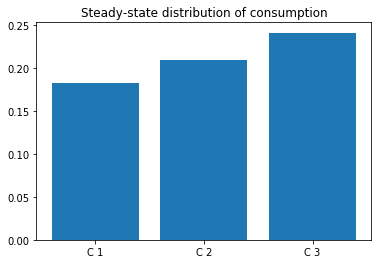

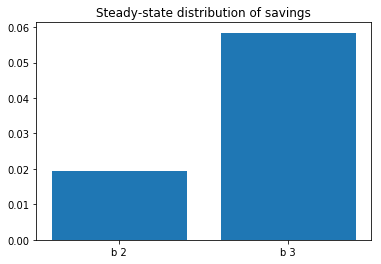

{'C_ss': 0.63290128279303526,
 'EulErr_ss': array([  4.58641125e-10,  -8.88931595e-10]),
 'K_ss': 0.077724326117900477,
 'RCerr_ss': 6.9388939039072284e-18,
 'Y_ss': 0.68276253216897786,
 'b_ss': array([ 0.01931274,  0.05841159]),
 'c_ss': array([ 0.18241256,  0.20961491,  0.24087382]),
 'r_ss': 2.4330302535700885,
 'ss_time': 0.0008119999999998129,
 'w_ss': 0.20172529359537983}

In [24]:
bvec_guess = np.array([0.1, 0.1])
ss_tol = 1e-6
L = nvec.sum()
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]
get_ss(params, bvec_guess, ss_graphs = True)

##### Part (c) :

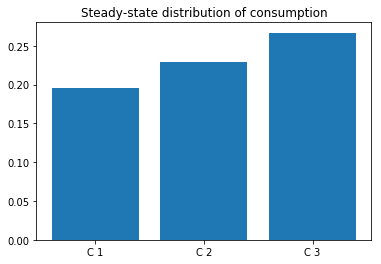

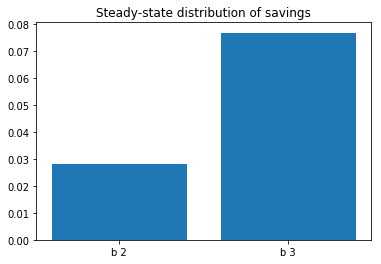

{'C_ss': 0.691283104418148,
 'EulErr_ss': array([ -6.82537689e-08,  -2.50616949e-08]),
 'K_ss': 0.10504252544893955,
 'RCerr_ss': 0.0,
 'Y_ss': 0.75866936323940171,
 'b_ss': array([ 0.02817696,  0.07686557]),
 'c_ss': array([ 0.19597535,  0.22861559,  0.26669216]),
 'r_ss': 1.8863600000635481,
 'ss_time': 0.0007529999999995596,
 'w_ss': 0.22415231186618687}

In [25]:
# Set beta to 0.55
beta = 0.55 
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]
get_ss(params, bvec_guess, ss_graphs = True)

#### Exercise 2.3 - TPI

In [26]:
# Set parameters
# 20-year discount factor
beta = 0.96**20  
# Steady-state horizon
T = 30 
# tolerance epsilon
epsilon = 1e-9                   
xi = 0.3
# Labour supply
nvec = np.array([1, 1, 0.2])
# tolerance for Euler errors
eul_tol = 1e-6                
max_iter = 10000
params = [beta, sigma, nvec, L, A, alpha, delta, eul_tol, max_iter]

In [28]:
# Solve for the steady-state first
output_ss = get_ss(params, bvec_guess)
b2_bar = output_ss['b_ss'][0]
b3_bar = output_ss['b_ss'][1]
b_ss = np.array([b2_bar, b3_bar])

In [29]:
# Set initial condition
b2_1 = 0.8 * b2_bar
b3_1 = 1.1 * b3_bar
bvec_guess = np.array([b2_1, b3_1])

In [30]:
# Initial linear guess path of K
K_1 = b2_1 + b3_1
K_bar = b2_bar + b3_bar
K_path = np.linspace(K_1, K_bar, T)
K_path = np.append(K_path, K_bar)

In [31]:
# Define a function to get interest rates and wages paths depending on capital path
def get_wr_paths(T, K_path, K_bar, params):
    
    r_path = np.zeros(T)
    w_path = np.zeros(T)
    for i in range(T):
        r_path[i] = get_r(K_path[i], params)
        w_path[i] = get_w(K_path[i], params)
    r_bar = get_r(K_bar, params)
    w_bar = get_w(K_bar, params)
    r_path = np.append(r_path, r_bar)
    w_path = np.append(w_path, w_bar)
    
    return np.array([r_path, w_path])

In [49]:
# Define a function to compute the Euler Errors for b3_2
def b3_2_EulErr(b3_2, b3_2_params):
    """ 
    b3_2_params = (b2_1, b2_2, r_path, w_path, params)
    
    """
    
    b2_1 = b3_2_params[0]
    b2_2 = b3_2_params[1]
    r_path = b3_2_params[2]
    w_path = b3_2_params[3]
    params = b3_2_params[4]
    
    c1 = (1 + r_path[0]) * b2_1 + w_path[0] * params[2][1] - b3_2
    u1 = u_prime(c1, params)
    c2 = (1 + r_path[1]) * b3_2 + w_path[1] * params[2][2]
    u2 = u_prime(c2, params)
    
    EulErr = u1 - params[0] * (1 + r_path[1]) * u2
    
    return EulErr

In [50]:
# Define a function to get the Euler errors for b3_2
def get_b3_2(b2_1, b2_2, r_path, w_path, params, bvec_guess):
    
    b3_2_params = [b2_1, b2_2, r_path, w_path, params]
    opt_result = opt.root(b3_2_EulErr, 
                      bvec_guess[0], 
                      args = b3_2_params, 
                      tol = params[7])
    b3_2 = opt_result.x
    b3_2_EulErrs = opt_result.fun
    
    return np.array([b3_2, b3_2_EulErrs])

In [34]:
# Define a function to compute Euler error for b2_t and b3_{t+1}

def b_EulErr(b, b_params):
    """ 
    Inputs:
    
    b = (b2_t, b3_t1)
    b_params = (t, r_path, w_path, params)
    
    """
    
    t  = b_params[0]
    r_path = b_params[1]
    w_path = b_params[2]
    params = b_params[3]
    
    c2_1 = w_path[t] * params[2][0] - b[0]
    u2_1 = u_prime(c2_1, params)
    c2_2 = (1 + r_path[t+1]) * b[0] + w_path[t+1] * params[2][1] - b[1]
    u2_2 = u_prime(c2_2, params)
    b2_EulErrs = u2_1 - params[0] * (1 + r_path[t+1]) * u2_2
    
    c3_1 = (1 + r_path[t+1]) * b[0] + w_path[t+1] * params[2][1] - b[1]
    u3_1 = u_prime(c3_1, params)
    c3_2 = (1 + r_path[t+2]) * b[1] + w_path[t+2] * params[2][2]
    u3_2 = u_prime(c3_2, params)
    b3_EulErrs = u3_1 - params[0] * (1 + r_path[t+2]) * u3_2
        
    return np.array([b2_EulErrs, b3_EulErrs])

In [35]:
# Define a function to get the Euler errors for b2_t and b3_{t+1}

def get_b(t, r_path, w_path, params, bvec_guess):
    
    b_params = [t, r_path, w_path, params]
    opt_result = opt.root(b_EulErr, 
                      bvec_guess, 
                      args = b_params, 
                      tol = params[7])
    b = opt_result.x
    b_EulErrs = opt_result.fun
    
    return np.array([b, b_EulErrs])

In [36]:
# Define a function to compute aggregate errors for each time path

def aggregate_errs(K_path, r_path, w_path, b_mat, params):
    
    L = params[2].sum()
    C = L * w_path[:-1] + (1 + r_path[:-1]) * b_mat[:-1,0] - b_mat[1:,0] + (1 + r_path[:-1]) * b_mat[:-1,1] - b_mat[1:,1]
    Y = params[4] * (K_path[:-1]**params[5]) * L**(1 - params[5])
    
    agg_err = Y - C - K_path[1:] + (1 - params[6]) * K_path[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err

In [45]:
# Define a function to compute time path of the b_2t and b_3t, Euler errors and aggregate resources errors

def bt_timepath(T, r_path, w_path, K_path, bvec_guess, b_ss, params):
    
    b_mat = np.zeros((T+1, 2))
    b_mat[0,:] = bvec_guess
    EulErrs = np.zeros((T+1, 2))
    col = [0,1]
    for i in range(T-1):
        row = [i+1, i+2]
        b_mat[row, col], EulErrs[row, col] = get_b(i, r_path, w_path, params, bvec_guess)
    
    b_mat[1,1], EulErrs[1,1] = get_b3_2(b_mat[0,0], b_mat[0,1], r_path, w_path, params, bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis = 0)
    agg_errs = aggregate_errs(K_path, r_path, w_path, b_mat, params)
    
    return b_mat, max_EulErrs, agg_errs

In [46]:
# Define a function to compute K'
def K_prime(b_mat, K_bar):
    
    K_pri_path = b_mat[:-1,:].sum(axis = 1)
    K_pri_path = np.append(K_pri_path, K_bar)
    
    return K_pri_path

In [47]:
# Define a function to compute TPI to get the equilibrium time path of the economy

def TPI(T, K_path, K_bar, bvec_guess, b_ss, params, epsilon, max_iter):
    
    dist = epsilon + 1
    i = 0
    
    while (dist > epsilon) & (i < max_iter):
        i += 1
        r_path, w_path = get_wr_paths(T, K_path, K_bar, params)
        b_mat, max_EulErrs, max_agg_errs = bt_timepath(T, r_path, w_path, K_path, bvec_guess, b_ss, params)
        K_pri_path = K_prime(b_mat, K_bar)
        dist = la.norm(K_pri_path - K_path, 2)
        K_path = xi * K_pri_path + (1 - xi) * K_path
        
    print('Maximum of the absolute values of the Euler errors for generation 2 is: ', max_EulErrs[0])
    print('Maximum of the absolute values of the Euler errors for generation 3 is: ', max_EulErrs[1])
    print('Maximum of the absolute value of all the aggregate resource constraint error is:', max_agg_errs)
    
    return K_path, r_path, w_path

##### Part (a)

In [51]:
Ks_path, rs_path, ws_path = TPI(T, K_path, K_bar, bvec_guess, b_ss, params, epsilon, max_iter)

Maximum of the absolute values of the Euler errors for generation 2 is:  3.21339115317e-07
Maximum of the absolute values of the Euler errors for generation 3 is:  9.46420044556e-08
Maximum of the absolute value of all the aggregate resource constraint error is: 0.0193127346375


##### Part (b)

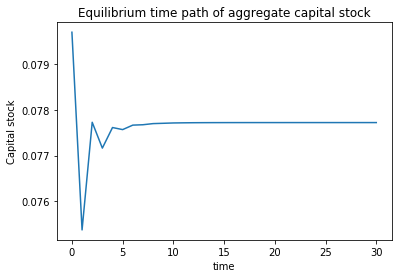

In [53]:
# Plot the equilibrium time paths of the aggregate capital stock
plt.plot(Ks_path)
plt.title('Equilibrium time path of aggregate capital stock')
plt.xlabel('time')
plt.ylabel('Capital stock')
plt.show()

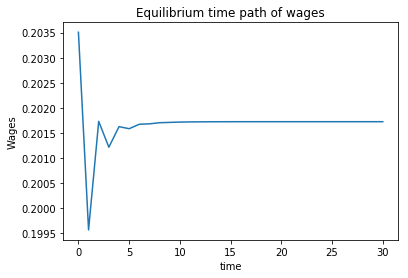

In [54]:
# Plot the equilibrium time paths of wages
plt.plot(ws_path)
plt.title('Equilibrium time path of wages')
plt.xlabel('time')
plt.ylabel('Wages')
plt.show()

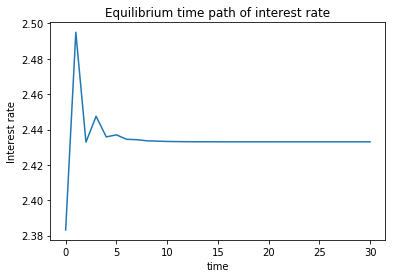

In [55]:
# Plot the equilibrium time paths of interest rate
plt.plot(rs_path)
plt.title('Equilibrium time path of interest rate')
plt.xlabel('time')
plt.ylabel('Interest rate')
plt.show()

##### Part (c)

In [56]:
Ks_dist = np.abs(Ks_path - K_bar)
err = 1e-5
loc = np.where(Ks_dist < err)[0]

In [59]:
print('Number of periods taken by the economy to get within 0.00001 of the steady state aggregate capital stock K is: ')
print(loc.min())

Number of periods taken by the economy to get within 0.00001 of the steady state aggregate capital stock K is: 
2


In [60]:
loc_cons = np.ediff1d(loc) == 1
print('The period after which the economy stays within 0.00001 of the steady state aggregate capital is: ')
print(loc[-len(loc_cons)])

The period after which the economy stays within 0.00001 of the steady state aggregate capital is: 
10
